# Article Clustering

In [1]:
import re
import json
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt

### Load Data

In [2]:
with open('Data/count_ccs.json', 'r') as fp:
    count_ccs = json.load(fp)
 
    # Print the type of data variable
    print("Type:", type(count_ccs))

with open('Data/count_ccs_root.json', 'r') as fp:
    count_ccs_root = json.load(fp)

with open('Data/count_ccs_kw.json', 'r') as fp:
    count_ccs_kw = json.load(fp)

with open('Data/articles_dict.json', 'r') as fp:
    articles_dict = json.load(fp)

Type: <class 'dict'>


###### Create dict

In [3]:
articles_df = pd.DataFrame(articles_dict)
articles_df.tail()

,doi,abstract,ft_body,ccs,keywords
107908,10.1145/2767134,<p>Online social media allow users to interact...,\n Detection of Political Manipulation in Onli...,{'CCS->Information systems->World Wide Web->We...,"[online social media, machine learning, opinio..."
107909,10.1145/2767135,<p>A classifier that determines if a webpage i...,\n Improving Researcher Homepage Classi.cation...,{'CCS->Information systems->Information retrie...,"[researcher homepage classification, co-traini..."
107910,10.1145/2789211,<p>There has been a recent swell of interest i...,\n Diversionary Comments under Blog Posts JING...,{'Mathematics of computing~Bayesian networks':...,"[diversionary comments, classification, corefe..."
107911,10.1145/2790304,<p>This work addresses the problem of estimati...,\n Estimating Clustering Coef.cients and Size ...,{'CCS->Theory of computation->Design and analy...,"[estimation, clustering coefficient, sampling,..."
107912,10.1145/2812812,<p>The Web 2.0 brought new requirements to the...,\n Fona: Quantitative Metric to Measure Focus ...,{'CCS->Hardware': 500},"[aria, focus navigation, web accessibility]"


##### Create Key Word (KW) dataframe

In [4]:
kw_count_avg = 0
kw_count_max = 0
kw_entry_num = 1
kw_agg_dict  = {}

for val in count_ccs_kw.values():
    for kw, count in val.items():
        kw_count_avg += (count-kw_count_avg)/kw_entry_num
        if(kw_count_max < count):
            kw_count_max = count
        kw_entry_num+=1

        if kw in kw_agg_dict.keys():
            kw_agg_dict[kw] += 1
        else:
            kw_agg_dict[kw]  = 1

print(kw_count_max, kw_count_avg, kw_entry_num, len(kw_agg_dict))

157 1.3422719298434838 463422 69554


In [5]:
kw_agg_df = pd.DataFrame({"keyword_names": kw_agg_dict.keys(), "occurences": kw_agg_dict.values()})
kw_agg_df.tail()

,keyword_names,occurences
69549,invertible bloom lookup tables,4
69550,low-density parity check codes,4
69551,shingled write disk,1
69552,emotion label,3
69553,cold-start system,3


In [6]:
num_kw_above_3 = kw_agg_df[kw_agg_df['occurences'] >=3].shape[0]
print("Number of keywords that occur more than three times:", num_kw_above_3)

Number of keywords that occur more than three times: 49060


In [7]:
kw_agg_df.describe()

,occurences
count,69554.000000
mean,6.662751
std,12.134835
min,1.000000
25%,2.000000
50%,4.000000
75%,7.000000
max,417.000000


### Vectorization of Keywords in a Doc for Hierarchical Clustering

#### BOW Binary

In [8]:
def sentence_vector(sentence, vocab_words):
    return [1 if token in sentence else 0 for token in vocab_words]

In [9]:
## Filters the dataframe only to include articles with keywords
filtered_articles_df = articles_df.dropna(subset='keywords')
# [articles_df['keywords'].notnull()]

## Sets the number of keywords used for vectorization
nb_key_words = int(5e3)
kw_vocab = kw_agg_df.sort_values("occurences")['keyword_names'][::-1][:nb_key_words].tolist()

## Computes the vector representation for each document
filtered_articles_df["BOWrepresentation_kw"]    = filtered_articles_df["keywords"].apply(lambda sentence: sentence_vector(sentence, kw_vocab))
filtered_articles_df.tail()

/tmp/ipykernel_508/4062777510.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_articles_df["BOWrepresentation_kw"]    = filtered_articles_df["keywords"].apply(lambda sentence: sentence_vector(sentence, kw_vocab))


,doi,abstract,ft_body,ccs,keywords,BOWrepresentation_kw
107908,10.1145/2767134,<p>Online social media allow users to interact...,\n Detection of Political Manipulation in Onli...,{'CCS->Information systems->World Wide Web->We...,"[online social media, machine learning, opinio...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
107909,10.1145/2767135,<p>A classifier that determines if a webpage i...,\n Improving Researcher Homepage Classi.cation...,{'CCS->Information systems->Information retrie...,"[researcher homepage classification, co-traini...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
107910,10.1145/2789211,<p>There has been a recent swell of interest i...,\n Diversionary Comments under Blog Posts JING...,{'Mathematics of computing~Bayesian networks':...,"[diversionary comments, classification, corefe...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
107911,10.1145/2790304,<p>This work addresses the problem of estimati...,\n Estimating Clustering Coef.cients and Size ...,{'CCS->Theory of computation->Design and analy...,"[estimation, clustering coefficient, sampling,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
107912,10.1145/2812812,<p>The Web 2.0 brought new requirements to the...,\n Fona: Quantitative Metric to Measure Focus ...,{'CCS->Hardware': 500},"[aria, focus navigation, web accessibility]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


##### Hierarchical Clustering

In [10]:
def ChooseMostImportantConcept(ccs):
    max_importance = 0
    associated_concept = np.nan
    for key, value in ccs.items():
        if value > max_importance:
            max_importance = value
            associated_concept = key
            
    return associated_concept

In [11]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

## Select a limited amount of articles
nb_articles   = int(5e1)
selected_data = filtered_articles_df.iloc[:, 5].array[:nb_articles]
selected_data = np.array([np.array(el) for el in selected_data])# Algorithm expects 2D array as an observation vector
artciles_doi  = filtered_articles_df['doi'].array[:nb_articles]
artciles_ccs  = filtered_articles_df['ccs'].apply(lambda x: ChooseMostImportantConcept(x)).array[:nb_articles]


# dist = euclidean_distances(selected_data)
dist = 1 - cosine_similarity(selected_data)

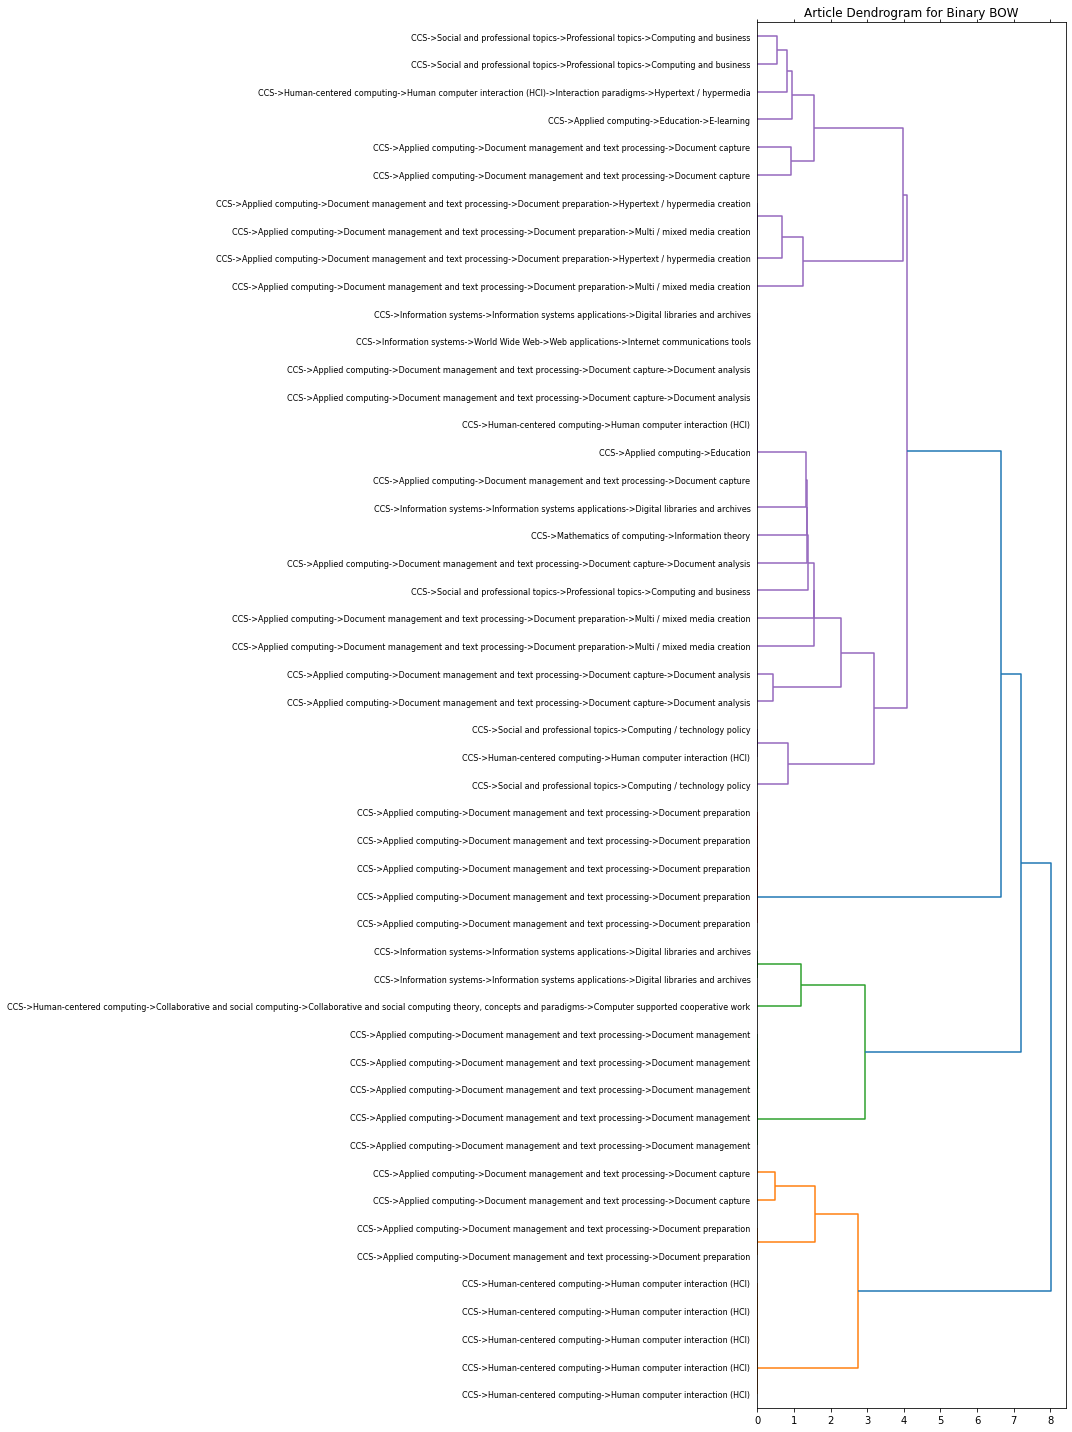

In [12]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
plt.title("Article Dendrogram for Binary BOW")

ax = dendrogram(linkage_matrix, orientation="right", labels=artciles_ccs);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('Images/ward_clusters_BinaryBOW.png', facecolor=fig.get_facecolor(), edgecolor='none', dpi=200) #save figure as ward_clusters

Metric  can be ‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’, ‘cosine’, ‘dice’, ‘euclidean’, ‘hamming’, ‘jaccard’, ‘jensenshannon’, ‘kulczynski1’, ‘mahalanobis’, ‘matching’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’.

#### Tf-Idf BOW

In [13]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

filtered_articles_df["keywords_str"]    = filtered_articles_df["keywords"].apply(lambda x: " ".join(x))


pipe_kw = Pipeline([('count', CountVectorizer(vocabulary=kw_vocab)),
                       ('tfidf', TfidfTransformer())]).fit(filtered_articles_df["keywords_str"])

/tmp/ipykernel_508/3486684680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_articles_df["keywords_str"]    = filtered_articles_df["keywords"].apply(lambda x: " ".join(x))


Compute the TF-IDF representation 

In [14]:
## List of arrays is a good solution to assign arrays as value in dataframe
tf_idf_list = list(pipe_kw.transform(filtered_articles_df["keywords_str"]).toarray())
np.array(tf_idf_list).shape

(40466, 5000)

In [15]:
filtered_articles_df["tf-idf_kw"] = tf_idf_list

/tmp/ipykernel_508/180704801.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_articles_df["tf-idf_kw"] = tf_idf_list


In [16]:
filtered_articles_df[["doi", "BOWrepresentation_kw", "tf-idf_kw"]].tail()

,doi,BOWrepresentation_kw,tf-idf_kw
107908,10.1145/2767134,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
107909,10.1145/2767135,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
107910,10.1145/2789211,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
107911,10.1145/2790304,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5349538701806..."
107912,10.1145/2812812,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


##### Hierarchical Clustering

In [17]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

## Select a limited amount of articles
nb_articles   = int(5e1)
selected_data = filtered_articles_df.iloc[:, 7].array[:nb_articles]
selected_data = np.array([np.array(el) for el in selected_data])# Algorithm expects 2D array as an observation vector
artciles_doi  = filtered_articles_df['doi'].array[:nb_articles]
artciles_ccs  = filtered_articles_df['ccs'].apply(lambda x: ChooseMostImportantConcept(x)).array[:nb_articles]


# dist = euclidean_distances(selected_data)
dist = 1 - cosine_similarity(selected_data)

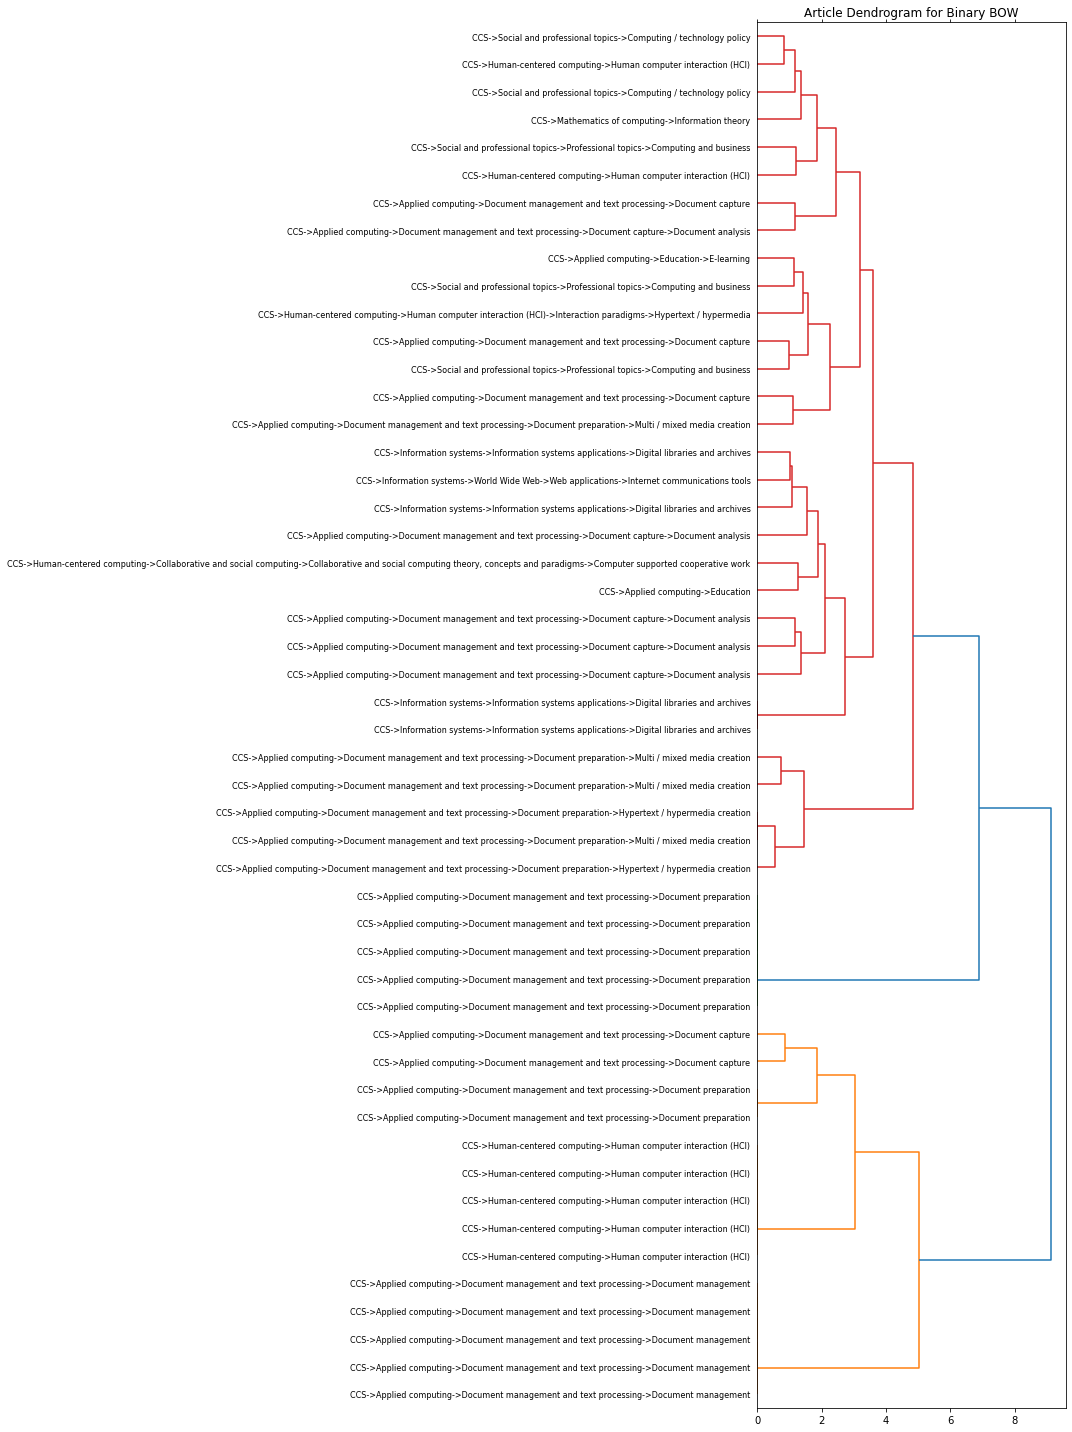

In [18]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
plt.title("Article Dendrogram for Binary BOW")

ax = dendrogram(linkage_matrix, orientation="right", labels=artciles_ccs);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('Images/ward_clusters_TF-IDFBOW.png', facecolor=fig.get_facecolor(), edgecolor='none', dpi=200) #save figure as ward_clusters

#### PCA

In [20]:

from sklearn.decomposition import PCA


pca = PCA(n_components=30)
principalComponents = pca.fit_transform(np.array(list(filtered_articles_df["tf-idf_kw"])))


principalDf = pd.DataFrame(data = principalComponents[:,:3],#we only take the first 3 components
             columns = ['principal component 1', 'principal component 2', 'principal component 3'])

principalDf

,principal component 1,principal component 2,principal component 3
0,-0.003072,-0.017627,-0.007754
1,0.019986,-0.048083,0.006816
2,0.004853,-0.021650,-0.005216
3,-0.005501,-0.014585,-0.009948
4,-0.003072,-0.017627,-0.007754
...,...,...,...
40461,0.012497,-0.042406,-0.065267
40462,-0.074564,0.074463,-0.086092
40463,-0.007177,-0.002363,0.005600
40464,-0.119629,-0.050869,-0.064031


In [ ]:
compute_transformation = False
if(compute_transformation):
    principalDf = principalDf.apply(lambda x: np.tan(x*np.pi/2))

In [21]:
articles_ccs  = filtered_articles_df['ccs'].apply(lambda x: ChooseMostImportantConcept(x))

In [22]:
targets = pd.DataFrame(data = list(articles_ccs),
              columns = ['ccs_concepts'])

finalDf = pd.concat([principalDf, targets], axis = 1)
finalDf

,principal component 1,principal component 2,principal component 3,ccs_concepts
0,-0.003072,-0.017627,-0.007754,CCS->Information systems->Information systems ...
1,0.019986,-0.048083,0.006816,CCS->Information systems->World Wide Web->Web ...
2,0.004853,-0.021650,-0.005216,CCS->Information systems->Information systems ...
3,-0.005501,-0.014585,-0.009948,CCS->Information systems->Information systems ...
4,-0.003072,-0.017627,-0.007754,CCS->Information systems->Information systems ...
...,...,...,...,...
40461,0.012497,-0.042406,-0.065267,CCS->Information systems->World Wide Web->Web ...
40462,-0.074564,0.074463,-0.086092,CCS->Information systems->Information retrieval
40463,-0.007177,-0.002363,0.005600,Mathematics of computing~Bayesian networks
40464,-0.119629,-0.050869,-0.064031,CCS->Theory of computation->Design and analysi...


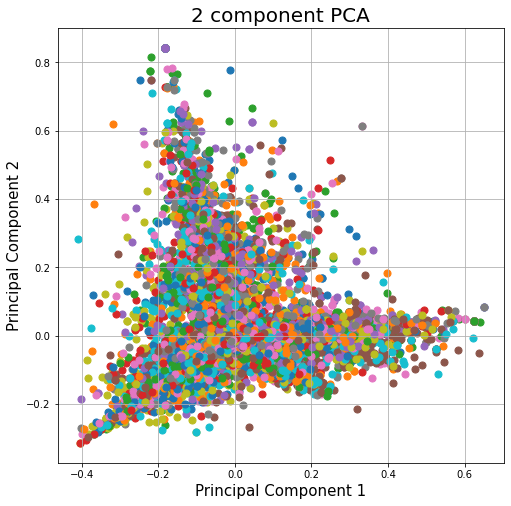

In [23]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = articles_ccs.unique()
# colors = ['r', 'g', 'b']
for target in targets:
    indicesToKeep = target == finalDf['ccs_concepts']
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
            #    , c = color
               , s = 50)
# ax.legend(targets)
ax.grid()

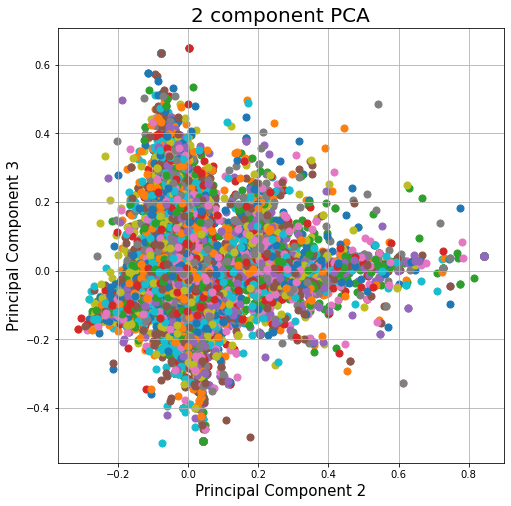

In [24]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 2', fontsize = 15)
ax.set_ylabel('Principal Component 3', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = articles_ccs.unique()
# colors = ['r', 'g', 'b']
for target in targets:
    indicesToKeep = target == finalDf['ccs_concepts']
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 2']
               , finalDf.loc[indicesToKeep, 'principal component 3']
            #    , c = color
               , s = 50)
# ax.legend(targets)
ax.grid()

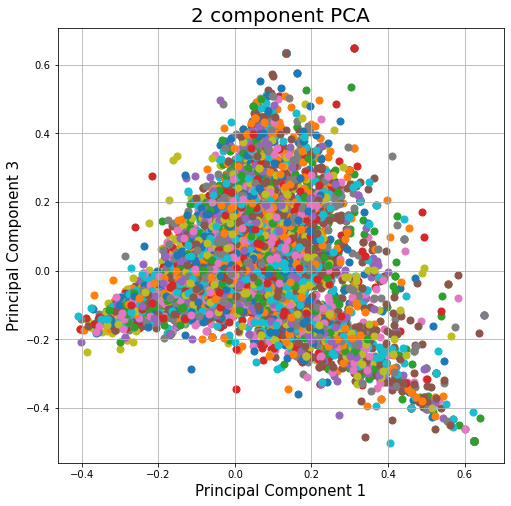

In [25]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 3', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = articles_ccs.unique()
# colors = ['r', 'g', 'b']
for target in targets:
    indicesToKeep = target == finalDf['ccs_concepts']
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 3']
            #    , c = color
               , s = 50)
# ax.legend(targets)
ax.grid()

##### Analyzing a smaller sample

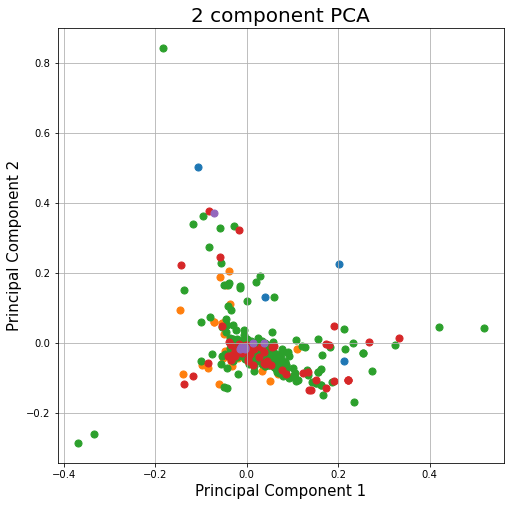

In [26]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = articles_ccs.unique()[:5]
# colors = ['r', 'g', 'b']
for target in targets:
    indicesToKeep = target == finalDf['ccs_concepts']
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
            #    , c = color
               , s = 50)
# ax.legend(targets)
ax.grid()

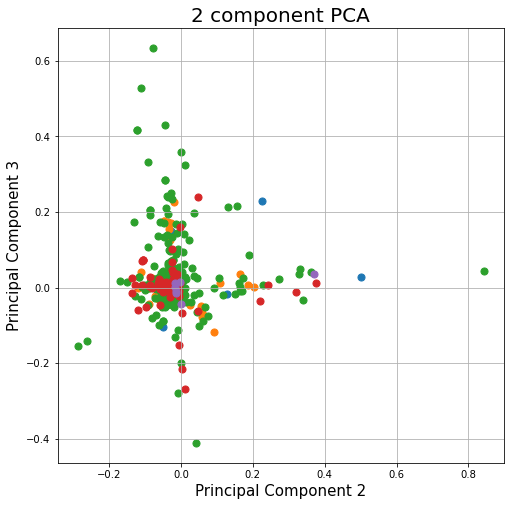

In [27]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 2', fontsize = 15)
ax.set_ylabel('Principal Component 3', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = articles_ccs.unique()[:5]
# colors = ['r', 'g', 'b']
for target in targets:
    indicesToKeep = target == finalDf['ccs_concepts']
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 2']
               , finalDf.loc[indicesToKeep, 'principal component 3']
            #    , c = color
               , s = 50)
# ax.legend(targets)
ax.grid()

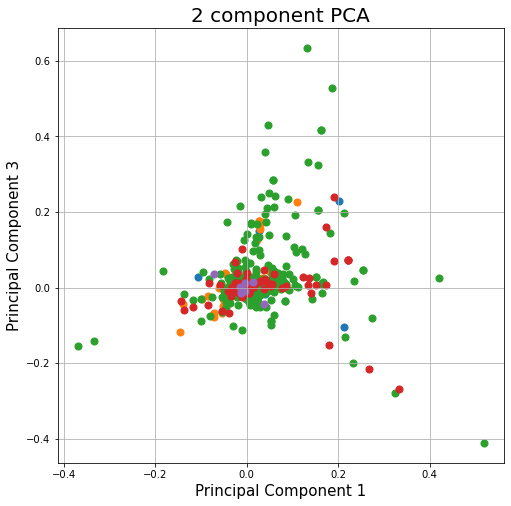

In [28]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 3', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = articles_ccs.unique()[:5]
# colors = ['r', 'g', 'b']
for target in targets:
    indicesToKeep = target == finalDf['ccs_concepts']
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 3']
            #    , c = color
               , s = 50)
# ax.legend(targets)
ax.grid()

##### PCA Explained

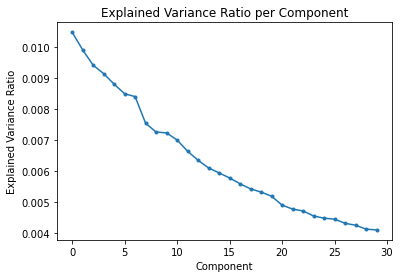

In [29]:
plt.plot(pca.explained_variance_ratio_, ".-")
plt.title("Explained Variance Ratio per Component")
plt.xlabel("Component")
plt.ylabel("Explained Variance Ratio")
plt.show()

In [37]:
print("Percentage of explained variance of the first three components is equal to : {}".format(np.sum(pca.explained_variance_ratio_[:3])))

Percentage of explained variance of the first three components is equal to : 0.029806375954931415


##### K-means on PCA

In [38]:
from sklearn.cluster import KMeans

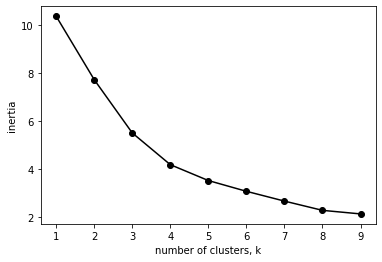

In [42]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    indicesToKeep = finalDf['ccs_concepts'].isin(articles_ccs.unique()[:5])
    # Fit model to samples
    model.fit(principalDf[indicesToKeep])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

Here $k=4$

In [49]:
kmeans_pca = KMeans(n_clusters=4)

indicesToKeep = finalDf['ccs_concepts'].isin(articles_ccs.unique()[:5])
new_df = principalDf[indicesToKeep]
# Fit model to samples
kmeans_pca.fit(new_df)

KMeans(n_clusters=4)

In [53]:
new_df['labels'] = kmeans_pca.labels_

/tmp/ipykernel_508/1497560754.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['labels'] = kmeans_pca.labels_


In [54]:
new_df

,principal component 1,principal component 2,principal component 3,labels
0,-0.003072,-0.017627,-0.007754,0
1,0.019986,-0.048083,0.006816,0
2,0.004853,-0.021650,-0.005216,0
3,-0.005501,-0.014585,-0.009948,0
4,-0.003072,-0.017627,-0.007754,0
...,...,...,...,...
40215,0.020522,-0.028851,0.050308,0
40235,0.133545,-0.092626,0.331407,3
40309,-0.011481,-0.012632,-0.015067,0
40388,-0.075190,-0.032840,-0.024262,0


/home/jcl/miniconda3/envs/ke/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


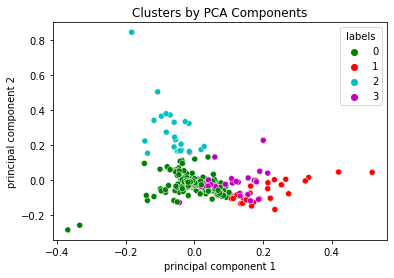

In [56]:
sns.scatterplot(new_df['principal component 1'], new_df['principal component 2'], hue=new_df['labels'], palette=['g', 'r', 'c', 'm'])
plt.title("Clusters by PCA Components")
plt.show()

/home/jcl/miniconda3/envs/ke/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


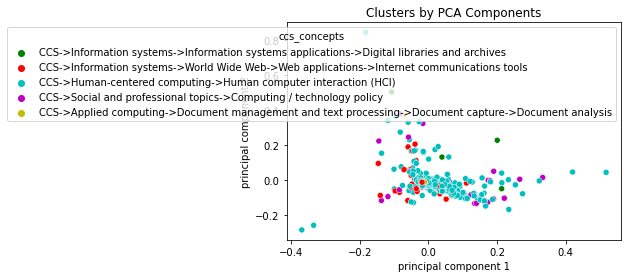

In [57]:
sns.scatterplot(new_df['principal component 1'], new_df['principal component 2'], hue=finalDf[indicesToKeep]['ccs_concepts'], palette=['g', 'r', 'c', 'm', 'y'])
plt.title("Clusters by PCA Components")
plt.show()